In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
from tests import *
from world import World
from grid import *
from queue import PriorityQueue
from graph import get_intended_path

inf = float("inf")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem Set - Incremental Path Planning

In this mini pset, you will implement an incremental path planning technique called D\* Lite to help a mobile robot navigate through an 8-connected grid world (that is, a grid where each cell has 8 neighbors).  First you'll learn about the data structures used by the algorithm, then you'll implement four helper functions, and finally you'll implement the main D\* Lite algorithm.

In this pset, the robot's knowledge of the world is imperfect. It knows the start node, the goal node, and its current position, but it has incomplete knowledge of the world because it can only see cells that are "nearby" (in this pset, we consider "nearby" cells to be the 8 neighbors of the cell). Hence, as the robot moves, it learns about the environment and updates its current "belief state" of the world. The robot does have memory: it will remember the status of any cells that it used to be in contact with.

To begin, we'll introduce the provided data structures. Please read and run the examples below, making sure that you understand the code and that there are no errors.

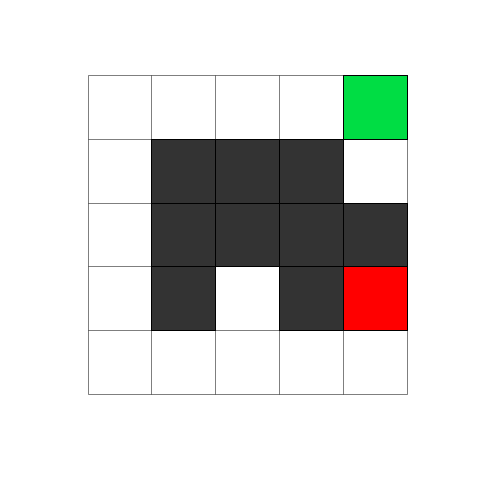

In [3]:
# Example: creating a grid from string and drawing it. We can easily create grids from strings
#  by using the Grid.create_from_str method. The grid string should be 'rectangular' with
#  entries as defined below, delimited by spaces:
#   0 -> free cell
#   1 -> obstacle
#   S -> starting point
#   G -> the goal
grid_str = """0 0 0 0 S
              0 1 1 1 0
              0 1 1 1 1
              0 1 0 1 G
              0 0 0 0 0"""
grid = Grid.create_from_str(grid_str)
d = grid.draw()

In the drawing above, black cells represent obstacles, white cells are passable, the start node is green, and the goal node is red.

Note that a grid does not store information about the robot or any path, just the state of the cells themselves.

Next we will convert a grid into a graph using a built in method.

/home/steve/miniconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/steve/miniconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


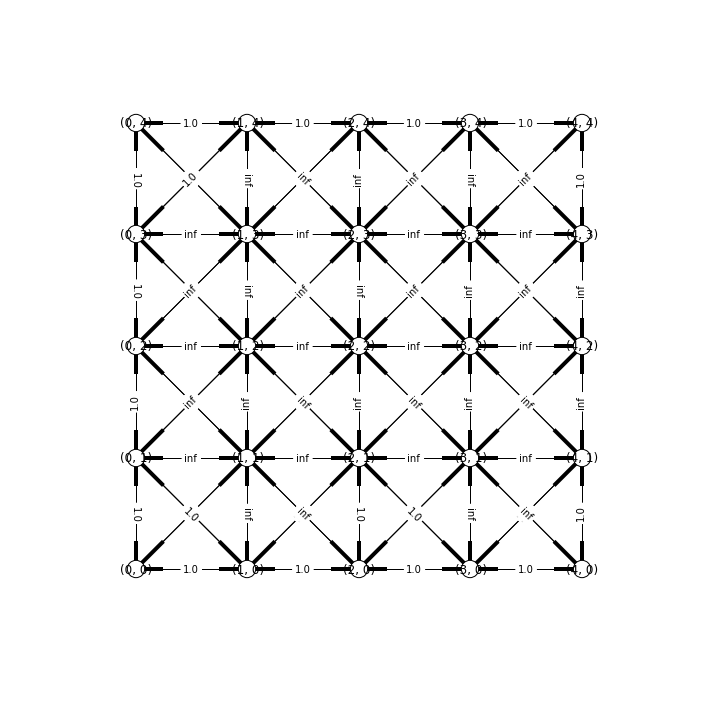

In [4]:
#Convert your grid to a graph
graph = grid.to_graph()
d = graph.draw()

Recall that our grids are 8-connected, so each node of this graph can have up to 8 (bi-directional) edges leading to its neighbors. Edges between passable cells are of unit weight, whereas edges to and from obstacle cells are of infinite weight. We will not be using this visualization much, since it's hard to tell from a quick glance what is going on.

Next we will learn about the World object.

A World object represents the belief-state and history of a robot. In particular, a World object stores what the world (as a grid) *looks like* to the robot at any particular point in time (the belief state), as well as what the world *really* looks like (the ground truth).

A World also stores:
* the current position of the robot as a tuple (x,y)
* the current discretized time, initialized at 0 and incremented by 1 whenever update_world is called (more details later)
* the path travelled by the robot thus far in the World

We also supply a method, update_world(path), that instigates an update to the environment. The details of this method will be explained later. For now, just know that this is the only way to mutate or update a World object.
    
In the examples below, read and run the provided code to:
- create a World from the grid you defined above, then display the robot's current knowledge of the world
- see the ground truth (what the world *really* looks like)
- use update_world to move the robot and see how its knowledge changes

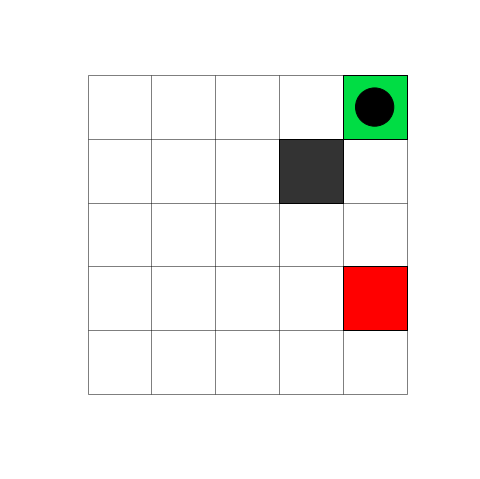

In [6]:
# An example of viewing and updating the world, drawing the
# world state at each time step.

# The World constructor takes in the grid, as well as the robot's start position as a tuple.
world = World(grid, (4, 4))
d = world.draw()

Calling world.draw() by default gives you the robot's understanding of its environment. Recall that a robot always knows its location, as well as the start and goal nodes, regardless of their distance from the robot. Besides the start and goal nodes, the robot knows the status of its own cell as well as the status of its 8 neighbors.

Next, we visualize the "ground truth" grid, which represents the true environment that the robot doesn't necessarily "know" about:

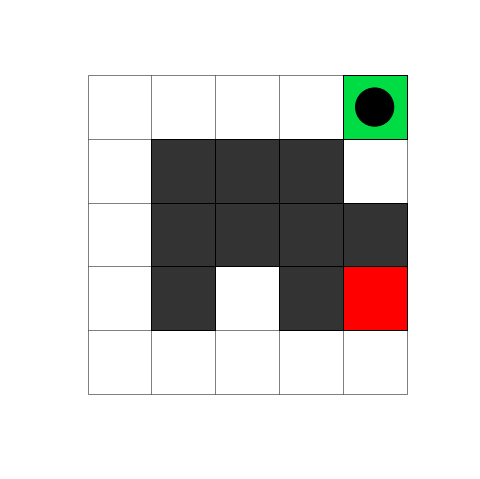

In [7]:
#Observe the ground truth
d = world.draw(ground_truth=True)

We supply this option so that you may have an easier time debugging.

Below, we explore the update_world method.

Typically, update_world method is called at every time step, taking in a path (an ordered list of tuples from the robot's new position to the goal) and updating the environment appropriately. In particular, update_world always
* updates the *ground truth* world to reflect, for example, moving obstacles or changing edge-weights, **and**
* updates the robot's *belief state* of the world, typically based on where the robot is, since it only knows for certain the statuses of its neighboring cells

with two important considerations:
1. Depending on the current time, the ground truth grid is not necessarily guaranteed to change. If there are no updates necessary (i.e. if there are no edge or obstacle changes), obviously nothing will change.
2. Depending on the robot's position (in particular, if the robot hasn't moved), the robot's belief state may not necessarily change. If the robot does not move, of course there is nothing new to see.

In this particular pset, we have chosen not to showcase moving obstacles. Instead, update_world only acts via updating the robot's belief state given its position.

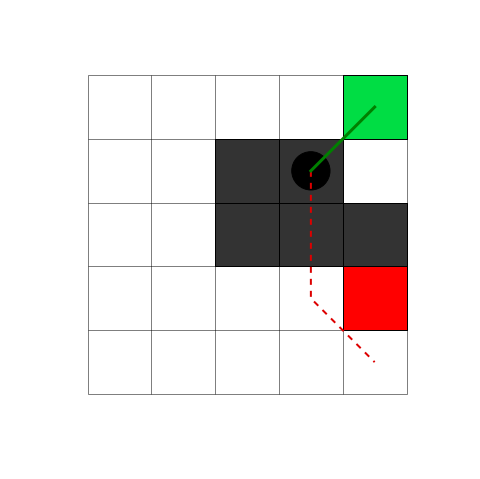

In [8]:
# Move the robot and observe how its knowledge of the world changes:
# Note that the input to update_world is an intended path, specified
# as a list of nodes that the robot plans to traverse to reach its goal.
# Recall that the robot started at (4,4). Hence, the first element of
# the path argument is *not* (4,4), but is instead the *next* step for
# the robot.
world = World(grid, (4, 4))
world.update_world([(3,3),(3,2),(3,1),(4,0)])
d = world.draw()

What have we done?! We first created the world, then updated the world with the next "intended path" for the robot. Calling world.draw() then lets us visualize where the robot is, as well as its path so far (green), and its intended future path (red).

In this clearly contrived example, the "intended path" ends at (4,0) which is not the goal node. Furthermore, the robot is now on top of an obstacle. Clearly these are not valid states. When implementing D\* Lite, you would obviously require paths to end at the goal node, and you would want your robot to only traverse non-obstacle cells.

Now, let's see how to get an *animated* view of the robot traveling along its path (solid green line), with its intended future path (red dashed line) displayed at each time step.

As soon as you execute the cell below, you should be able to watch a "live" animation of the robot moving. Don't miss it!

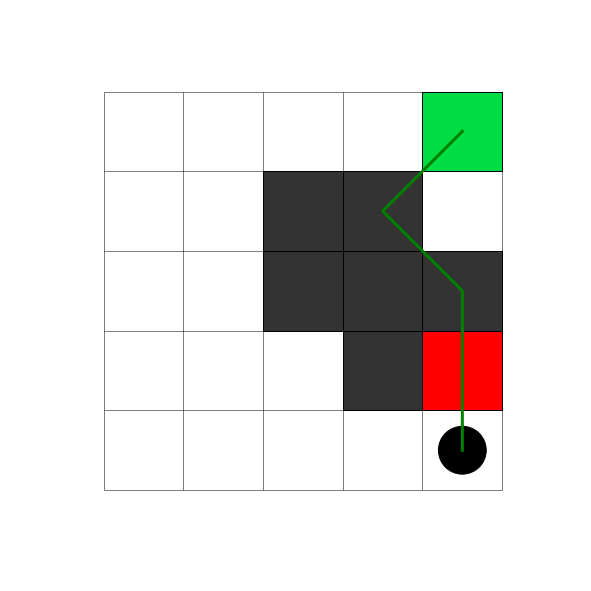

In [12]:
# Start with a fresh world with the robot at start position (4,4), and
#  call update_world several times, each time with the new "intended path"
#  for the robot. Once, the robot reaches (4,0), we call world.draw_all_path()
world = World(grid, (4, 4))
world.update_world([(3,3),(3,2),(3,1),(4,0)])
world.update_world([(4,2),(4,1),(4,0)])
world.update_world([(4,1),(4,0)])
world.update_world([(4,0)])

world.draw_all_path()

Again, in this example, the robot's path is clearly invalid and does not end at the goal. Make sure your robot behaves correctly in your D\* Lite implementation!

<h2>D\* Lite Implementation</h2>

Now it's your turn to write code for the D\* Lite algorithm!

Our implementation of the algorithm uses the following variables:
- g: a dictionary mapping nodes to their current g-values
- rhs: a dictionary mapping nodes to their current rhs-values
- key_modifier: a number representing the current key modifier k_m
- queue: a PriorityQueue using calc_key as its priority function
- graph: the Graph representing the robot's initial map of the world. You'll want to update graph whenever the world changes.

First, you'll code some helper functions to be used in the D\* Lite algorithm.

Implement grid_heuristic and calc_key_helper, then run the tests below.

In [13]:
def grid_heuristic(node1, node2):
    """Given two nodes as (x,y) grid-coordinate tuples (e.g. (2,3)), computes the
    heuristic grid-based heuristic value between the nodes.
    (Hint: The heuristic value is just the maximum of the difference in x or y.)"""
    return max(map(abs, [node1[i]-node2[i] for i in (0,1)]))

In [14]:
def calc_key_helper(node, g, rhs, start, key_modifier, heuristic=grid_heuristic):
    "Computes the node's current key and returns it as a tuple of two numbers."
    min_g_rhs = min([g[node], rhs[node]])
    return (min_g_rhs + heuristic(start, node) + key_modifier, min_g_rhs)

In [15]:
# Test grid_heuristic and calc_key_helper
test_grid_heuristic(grid_heuristic)
test_calc_key_helper(calc_key_helper)
test_ok()

Testing grid_heuristic...
Testing calc_key_helper...


Tests passed!!

Next, you will implement a method for updating a vertex, following the pseudocode for D\* Lite.
(Recommended reference: <a href=http://pub1.willowgarage.com/~konolige/cs225b/dlite_tro05.pdf>2002 draft of Koenig & Likhachev's D\* Lite paper</a>.  The relevant pseudocode is on page 5.)

Some of the following Graph methods may be helpful:
- graph.get_all_nodes(): returns a set of all nodes in the graph
- graph.get_predecessors(node): returns a list of nodes that are predecessors of the input node
- graph.get_successors(node): returns a list of nodes that are successors of the input node
- graph.get_edge_weight(source, target): returns the edge weight of the edge from source to target, or raises a ValueError if no such edge exists.
- graph.get_edge(source, target): returns the Edge connecting source to target, or None if no such Edge exists.

An Edge is an object with three self-explanatory properties: edge.source, edge.target, and edge.weight.

Use the following methods to manipulate a PriorityQueue:
- queue.insert(item): inserts the item into the queue, automatically computing the item's key
- queue.remove(item): deletes all instances of the item from the queue

Implement update_vertex_helper, then run the tests below.

In [16]:
def update_vertex_helper(node, g, rhs, goal, graph, queue):
    """As in the D* Lite pseudocode, this method updates node's rhs value and
    queue status. Returns nothing."""
    if node != goal:
        rhs[node] = min([graph.get_edge_weight(node, neighbor) + g[neighbor]
                         for neighbor in graph.get_successors(node)])
    if node in queue:
        queue.remove(node)
    if g[node] != rhs[node]:
        queue.insert(node)

In [17]:
test_update_vertex_helper(update_vertex_helper)
test_ok()

Testing update_vertex_helper...


Tests passed!!

Just one more helper function before we get to the main function!  This function will closely follow ComputeShortestPath() from the D\* Lite pseudocode.

In addition to the methods mentioned above, the following may be useful:
- queue.pop(): removes the next item from the priority queue and returns it
- queue.top_key(): returns the key corresponding to the next item in the queue, without removing the item

Note that you can use the functions calc_key(node) and update_vertex(node) to
call your helper functions without needing to pass in all the arguments.

You can also use the constant inf to represent infinity.

Implement compute_shortest_path_helper, then run the tests below.

In [18]:
def compute_shortest_path_helper(g, rhs, start, goal, key_modifier, graph, queue):
    """As in the D* Lite pseudocode, this method computes (or recomputes) the
    shortest path by popping nodes off the queue, updating their g and rhs
    values, and calling update_vertex on their neighbors.  Returns nothing."""
    # Helper functions that take in only one argument, node:
    def calc_key(node):
        return calc_key_helper(node, g, rhs, start, key_modifier)
    def update_vertex(node):
        return update_vertex_helper(node, g, rhs, goal, graph, queue)

    verbose = False #set this to True to enable print statements below
    
    if verbose: print '> COMPUTE SHORTEST PATH'
    while True:
        smallest_key = queue.top_key()
        if smallest_key >= calc_key(start) and rhs[start] == g[start]:
            break
        node = queue.pop()
        if verbose: print '> dequeue node', node, 'with h =', grid_heuristic(node, start)
        if smallest_key < calc_key(node):
            print smallest_key, calc_key(node), node
            queue.insert(node)
        elif g[node] > rhs[node]:
            g[node] = rhs[node]
            for next_node in graph.get_predecessors(node):
                update_vertex(next_node)
        else:
            g[node] = inf
            for next_node in graph.get_predecessors(node) + [node]:
                update_vertex(next_node)


In [19]:
test_compute_shortest_path_helper(compute_shortest_path_helper,calc_key_helper)
test_ok()

Testing compute_shortest_path_helper...


Tests passed!!

Now it's time to implement the main D\* Lite function!

Our implementation of the algorithm will take in an IncrementalSearchProblem object, which has the following properties and methods:
- problem.start_node
- problem.goal_node
- problem.is_robot_at_goal(): returns True if robot is at goal_node, otherwise False
- problem.get_graph(): returns a Graph representing the robot's current belief state, or knowledge of the world
- problem.update_world(intended_path): given an intended path as a list of nodes, updates the robot's belief graph and returns the updated graph. This is the only way to update an IncrementalSearchProblem. You do not need to call world.update_world() directly.

In the pseudocode for D\* Lite, the algorithm only keeps track of the robot's next step (s_start), not its entire planned
path.  To get the planned path, you can use this helper function:

- get_intended_path(next_step, goal, graph, g)

get_intended_path takes in a node next_step indicating where the robot will move to next (i.e.
since the last update), the goal node, the robot's current graph, and the dict
of g-values.  It uses g-values to reconstruct and return the robot's planned
path as a list of nodes [next_step, ... , goal], which is exactly the intended_path argument
required by problem.update_world.


If you want to see which edges are different between two graphs, you can use this Graph method:

- my_graph.get_changed_edges(other_graph): returns a set of tuples (my_edge, their_edge) containing corresponding pairs of edges whose weights differ between the two graphs.

In case you need to make a deep copy of a Queue, Graph, or IncrementalSearchProblem, we've provided a .copy() method in each of those classes. This method will return a deep copy of the object in question.


As above, you can use the functions calc_key(node) and update_vertex(node), as
well as compute_shortest_path() and heuristic(node1, node2), to call your helper 
functions without needing to pass in all the arguments.

In the dstar_lite method below, we've implemented all the initialization for
you.  We recommend reading the comments in the INITIALIZE section to understand
what is going on.  Then, implement the rest of D\* Lite, using the provided API
and following the D\* Lite pseudocode.  When you're done, you can test your
implementation in the test block below.

In [20]:
def dstar_lite(problem):
    """Performs D* Lite to incrementally find a shortest path as the robot
    moves through the graph.  Updates the IncrementalSearchProblem, problem, by
    calling problem.update_world.  The search terminates when the robot either
    reaches the goal, or finds that there is no path to the goal.  Returns the
    modified problem.

    Note: The world is dynamic, so the true positions of obstacles may change as
    the robot moves through the world.  However, if the robot determines at any
    point that there is no finite path to the goal, it should stop searching and
    give up, rather than waiting and hoping that the world will improve.
    """

    ############################################################################
    # INITIALIZE

    # Get the start node, goal node, and graph from the IncrementalSearchProblem
    start = problem.start_node
    goal = problem.goal_node
    graph = problem.get_graph()

    # Set g=inf and rhs=inf for all nodes, except the goal node, which has rhs=0
    g = {node:inf for node in graph.get_all_nodes()}
    rhs = {node:inf for node in graph.get_all_nodes()}
    rhs[goal] = 0

    # Set the key modifier k_m to 0
    key_modifier = 0

    # Define shortened helper functions
    def calc_key(node):
        return calc_key_helper(node, g, rhs, start, key_modifier)
    queue = None # to be reinitialized later
    def update_vertex(node):
        return update_vertex_helper(node, g, rhs, goal, graph, queue)
    def compute_shortest_path():
        return compute_shortest_path_helper(g, rhs, start, goal, key_modifier, graph, queue)
    heuristic = grid_heuristic

    # Initialize the queue using the priority function calc_key
    queue = PriorityQueue(f=lambda node: calc_key(node))
    queue.insert(goal)

    ############################################################################
    verbose = False #set this to True to enable print statements below
    
    # Begin algorithm
    last_start = start
    compute_shortest_path()
    if verbose: print 'robot starting at:', start

    while start != goal:
        if g[start] == inf:
            if verbose: print "no path found"
            return problem
        start = min(graph.get_successors(start),
                    key = lambda neighbor: (graph.get_edge_weight(start, neighbor)
                                            + g[neighbor]))
        old_graph = graph.copy()
        if verbose: print 'robot moving to:', start
        intended_path = get_intended_path(start, goal, graph, g)
        if verbose: print 'intended path:', intended_path
        graph = problem.update_world(intended_path)
        changed_edges = old_graph.get_changed_edges(graph)
        if changed_edges:
            key_modifier = key_modifier + heuristic(last_start, start)
            last_start = start
            for (old_edge, new_edge) in changed_edges:
                if old_edge and new_edge: #edge simply changed weight
                    update_vertex(old_edge.source)
                elif not old_edge: #new edge was added
                    raise NotImplementedError("Edge addition not yet supported")
                else: #old edge was deleted
                    raise NotImplementedError("Edge deletion not yet supported")
            compute_shortest_path()
    return problem #contains path traversed, intended future path, and other info

Tests passed!!

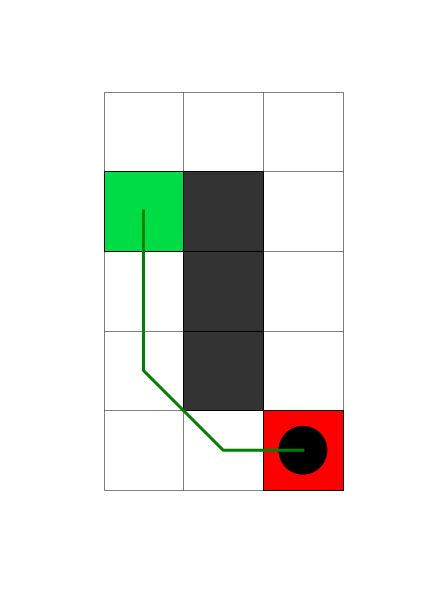

In [21]:
# This test uses the example from page 6 of Koenig & Likhachev's paper, referenced above.
test_dstar_lite(dstar_lite)
test_ok()

Once all the tests above pass, you're done!  

If you want to try your D\* Lite algorithm on a larger (40x30) grid, run the function below. This will probably take several minutes, so please be patient! (On our machines, it took between 2 and 3 minutes.) Instead of automatically starting the animation after the algorithm as finished, we simply return the problem so that in the next cell you can call problem.draw_all_path()

In [ ]:
hard_problem_done = run_dstar_lite_hard_grid(dstar_lite)

Assuming that the above cell ran successfully, you can now watch the robot's trajectory!

In [ ]:
hard_problem_done.draw_all_path(time_step=0.5)